In [3]:
from zipfile import ZipFile
import csv
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import models, layers

In [ ]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip -O data.zip

with ZipFile('data.zip', 'r') as zipObj:
   zipObj.extractall()
   print('Finish extracting')

&lt;AxesSubplot:ylabel=&#39;Frequency&#39;&gt;

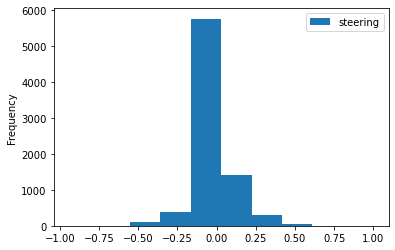

In [4]:
log_data = pd.read_csv('./data/driving_log.csv')  
log_data.drop(columns=['throttle','brake','speed'],inplace=True)
log_data.head()
log_data.plot.hist()

In [5]:
def batch_loader(log_select):
    images = []
    measurements = []
    for l in log_select.itertuples():
        path = './data/'+l.center
        image = cv2.imread(path)
        if image is not None :
            images.append(image)
            measure = l.steering
            measurements.append(measure)
        else:
            print('Image not read',path)
    return np.asarray(images),np.asarray(measurements)

def train_test_val(log_data_frame, train_ratio, test_ratio, val_ratio):
    assert sum([train_ratio, test_ratio, val_ratio])==1.0
    log_data_frame = shuffle(log_data_frame)
    data_size = len(log_data_frame)
    id_train = int(round(data_size*train_ratio))
    id_test = int(round(data_size*(train_ratio+test_ratio)))

    train = log_data_frame[:id_train]
    test = log_data_frame[id_train:id_test]
    validation = log_data_frame[id_test:]
    #print(len(log_data_frame),len(train)+len(test)+len(validation))
    return train, test, validation

def flip(in_images,in_labels):
    result_images =[]
    result_measures =[]
    for i,img in enumerate(in_images):
        result_images.append(np.fliplr(img))
        flip_measure = 0.0
        if in_labels[i] != 0.0:
            flip_measure = - in_labels[i]
        result_measures.append(flip_measure)
    
    result_images = np.asarray(result_images)
    result_measures = np.asarray(result_measures)
    assert len(in_images)==len(result_images)
    return result_images,result_measures

def convert_gray(images):
    return np.sum(images/3,axis=3,keepdims=True)

In [6]:
train, test, validation = train_test_val(log_data,0.6,0.2,0.2)
print(len(log_data),len(train),len(test),len(validation))
visualization_images,visualization_labels = batch_loader(train[:10])
print(visualization_images.shape,visualization_labels.shape)


8036 4822 1607 1607
(10, 160, 320, 3) (10,)


-0.05975719 0.05975719
(10, 160, 320, 1) (10, 160, 320, 1) (10,)


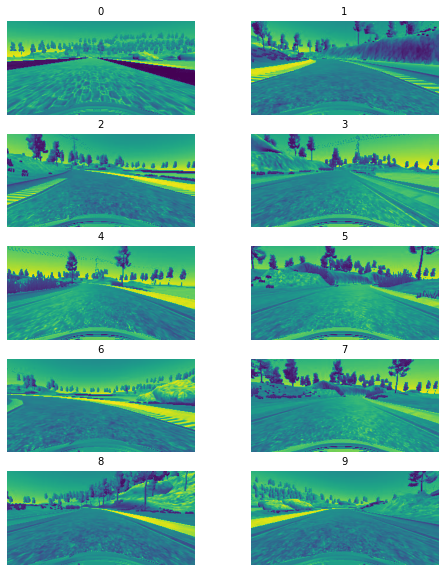

In [7]:
gray_images = convert_gray(visualization_images)
flip_images,flip_labels = flip(gray_images,visualization_labels)
print(visualization_labels[0],flip_labels[0])
print(gray_images.shape,flip_images.shape,flip_labels.shape)
fig, axes = plt.subplots(5,2, figsize=(8,10))

for i,ax in  enumerate(axes.flat):
    ax.set_title(i,fontsize=10)
    ax.imshow(gray_images[i])
    ax.set_axis_off()

In [8]:
def image_generator(logs, batch_size, mode='train'):
    while True:
        start = 0
        end = batch_size
        while start  < len(logs):
            selected = logs[start:end]
            images,labels = batch_loader(selected)
            images = convert_gray(images)
            images = (images-128)/128
            if mode=='train':
                flip_img,flip_labels = flip(images,labels)
                images = np.vstack((flip_img,images))
                labels = np.hstack((flip_labels,labels))
            yield images,labels
            start += batch_size
            end += batch_size


In [9]:
generator = image_generator(log_data[0:10],10)
gen_images,gen_labels=next(generator)
img_shape = gen_images[0].shape

In [10]:
model = models.Sequential()
model.add(layers.Convolution2D(6,5,5,activation='relu',input_shape=img_shape))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Convolution2D(6,5,5,activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(120))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(84))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [ ]:
history = model.fit(image_generator(train,64),
        validation_data=image_generator(validation,128,mode='validation'),
        shuffle=True,
        steps_per_epoch=100,
        epochs=1,
        verbose=1)


In [ ]:
model.save('model.h5')
